# Import customer product review data

Data source: https://www.kaggle.com/datasets/mehmetisik/amazon-review/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
from google.colab import files
uploaded = files.upload()

Saving amazon_review.csv to amazon_review.csv


In [3]:
df = pd.read_csv('amazon_review.csv')

In [4]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [5]:
print(df.shape)

(4915, 12)


# Data exploration

- 'overall' column shows the overall rating of the product given by a unique ReviewerID
- The rating ranges from 1-5
- Most customers rated the product positively, with the majority giving ratings of 5 or 4. While a smaller group gave a rating of 1.



In [6]:
# 'overall' column indicates customer ratings

df['overall'].unique()

array([4., 5., 3., 1., 2.])

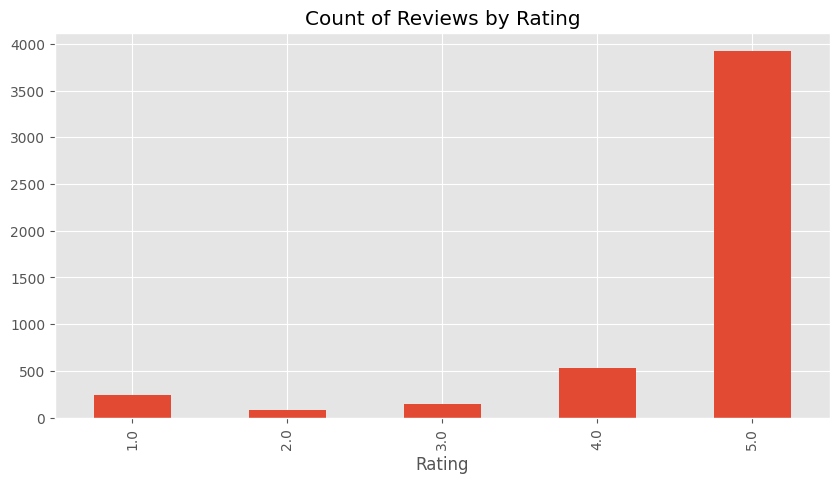

In [7]:
# if use sort_values() then sorted by number of counts

ax = df['overall'].value_counts().sort_index().plot(kind = 'bar',
                                                             title = 'Count of Reviews by Rating',
                                                             figsize = (10,5))
ax.set_xlabel('Rating')
plt.show()

# Solution 1: VADER Sentiment Analysis

or Valence Aware Dictionary and sEntiment Reasoner is designed to analyze the sentiment of text data with 4 key features:

1. **Lexicon-Based**: uses a pre-built lexicon of words that are mapped to their respective sentiment intensities (positive, neutral or negative).

2. **Handles Informal Language**: works well with text containing slang, emoticons, abbreviations, and even capitalization.

3. **Context Sensitivity**: takes into account factors like:
    - Punctuation: E.g., exclamation marks (!) increase intensity.
    - Capitalization: E.g., words in ALL CAPS are given more weight.
    - Degree Modifiers: Words like "very" or "extremely" amplify the sentiment score.
    - Negations: Words like "not" or "never" can reverse the sentiment.

4. **Outputs Compound and Polarity Scores**:
    - Compound Score: A normalized score between -1 (most negative) and +1 (most positive).
    - Positive, Negative, Neutral Scores: Proportions of text categorized as positive, negative, or neutral.

sources: https://github.com/cjhutto/vaderSentiment

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [9]:
sia.polarity_scores('I like it a lot!')

{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.4199}

In [10]:
sia.polarity_scores('I do not think this is good')

{'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'compound': 0.4404}

In [11]:
sia.polarity_scores('This is the worst thing ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [13]:
example = 'I LOVE that'
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.169, 'pos': 0.831, 'compound': 0.7125}

In [14]:
# convert 'reviewText' column into str to perform polarity_scores function
df['reviewText'] = df['reviewText'].astype(str)

In [15]:
df['reviewerID'].nunique()

4915

In [16]:
review = {}
for i, row in tqdm(df.iterrows(), total=len(df)): # use df.iterrows() to iterate through each row, store index in 'i' and other columns in 'row'
    text = row['reviewText']
    myid = row['reviewerID']
    review[myid] = sia.polarity_scores(text)

  0%|          | 0/4915 [00:00<?, ?it/s]

In [17]:
vaders = pd.DataFrame(review).T
vaders = vaders.reset_index().rename(columns={'index': 'reviewerID'})
vaders = vaders.merge(df, how='left') # match 'reviewerID' in vaders with 'reviewerID' in df and merge 4 columns to its left

In [18]:
vaders.head()

,reviewerID,neg,neu,pos,compound,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,0.688,0.312,0.000,-0.2960,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,0.075,0.925,0.000,-0.2960,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,0.077,0.923,0.000,-0.3089,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,0.000,0.909,0.091,0.7081,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,0.038,0.835,0.127,0.7087,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


# VADER Output

**Compound score:**
- The VADER method assigns compound scores that align with overall ratings. Low overall ratings (overall = 1 or 2) correspond to low average compound scores, and high ratings (overall = 4 or 5) correspond to high average scores.
- The confidence intervals (represented by black lines) do not overlap between high and low ratings.

**Negative - Neutral - Positive score:**
- Higher rating does have higher average positive score and lower rating also has higher average negative score.
- However, on a comparable scale, VADER consistently assigns high neutral scores across all rating levels.
- This might suggest that the **model may struggle to clearly differentiate between positive and negative sentiment** for certain types of text.




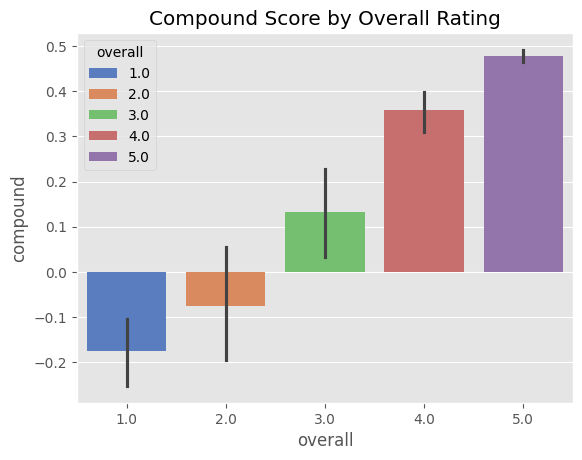

In [19]:
ax = sns.barplot(data=vaders, x='overall', y='compound', hue='overall', palette="muted")
ax.set_title('Compound Score by Overall Rating')
plt.show()

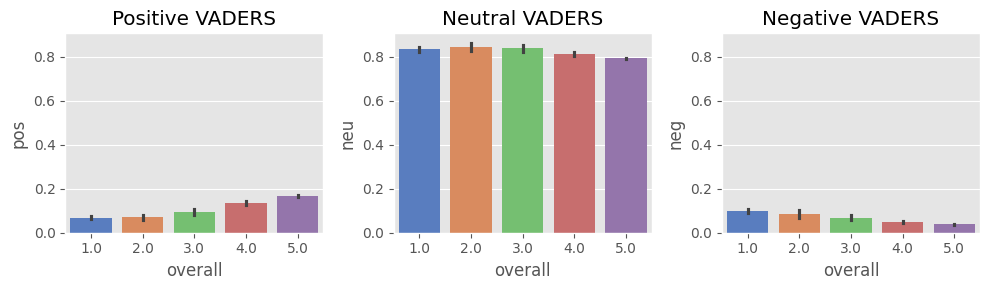

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
sns.barplot(data=vaders, x='overall', y='pos', ax=axs[0], hue='overall', palette="muted", legend=False)
sns.barplot(data=vaders, x='overall', y='neu', ax=axs[1], hue='overall', palette="muted", legend=False)
sns.barplot(data=vaders, x='overall', y='neg', ax=axs[2], hue='overall', palette="muted", legend=False)
axs[0].set_title('Positive VADERS')
axs[1].set_title('Neutral VADERS')
axs[2].set_title('Negative VADERS')

# Synchronize y-axis limits
y_min = 0
y_max = max(ax.get_ylim()[1] for ax in axs.flat)  # Find the maximum y limit across all subplots
for ax in axs.flat:
    ax.set_ylim(y_min, y_max)  # Set consistent y-axis limits for all subplots

plt.tight_layout()
plt.show()

# Solution 2: Roberta Pretrained Model

- The model is based on RoBERTa, which uses a transformer architecture with self-attention mechanisms to **understand the contextual relationships between words** in text.

- It is pretrained on large corpora of text, learning to encode linguistic features and relationships in the form of embeddings.

- This specific model `cardiffnlp/twitter-roberta-base-sentiment` is a pre-trained model **fine-tuned for sentiment analysis on Twitter data**.

# How does it work?

1. **Input Text**: A piece of text (e.g., a review) is provided as input to the model.

2. **Text Tokenization**: The AutoTokenizer splits the text into tokens, converts them into numerical IDs, and creates attention masks to indicate which tokens are meaningful.

3. **Transformer Encoding**: The tokenized input is processed by RoBERTa's transformer layers to create contextual embeddings for each token, with the [CLS]* token summarizing the entire sequence.

4. **Classification**:  The final layer of the model is a linear classification head. It takes the [CLS]* token's embedding and maps it to logits for each sentiment class.

5. **Prediction**: The logits are passed through the softmax function to calculate probabilities for each sentiment category.
The category with the highest probability is selected as the predicted sentiment.


\*
[CLS] is fixed special token added to the start of the sequence. Its purpose is to help the model understand that it needs to use the information from that token for classification.

source: https://huggingface.co/FacebookAI/roberta-base
        ,https://huggingface.co/docs/transformers/en/quicktour

In [21]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [22]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [23]:
# Run Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.006516018, 'roberta_neu': 0.024792043, 'roberta_pos': 0.96869195}


In [24]:
# define polarity score function for roberta

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [25]:
df['reviewText'] = df['reviewText'].astype(str)

In [26]:
# Skip some reviews that cause RuntimeError

review_roberta = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
  try:
    text = row['reviewText']
    myid = row['reviewerID']
    review_roberta[myid] = polarity_scores_roberta(text)
  except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/4915 [00:00<?, ?it/s]

Broke for id A1LP4NB5X34HF8
Broke for id A1UM44ILLZCEI1
Broke for id A1LRDKHATAJTHV
Broke for id A3FQ9WYUHG9CD
Broke for id A12B7ZMXFI6IXY
Broke for id A1AANYVDE04JF1
Broke for id A3VSG5X7GPNNW6
Broke for id A12ESGQ81M70JX
Broke for id ADPDMLUDAMML0
Broke for id A36U8X10T0BFVJ
Broke for id AOEAD7DPLZE53
Broke for id A18HE80910BTZI
Broke for id A2Y2HXLF29KBEC
Broke for id A14PJ6GP1GS4TM
Broke for id AVBMZZAFEKO58
Broke for id AWKYTPVNNZELL
Broke for id A1PPMB99YNFPRH
Broke for id A1WTQUOQ4WG9AI


In [27]:
roberta = pd.DataFrame(review_roberta).T
roberta = roberta.reset_index().rename(columns={'index': 'reviewerID'})
roberta_vaders_df = roberta.merge(vaders, how='left')

In [28]:
roberta_vaders_df.rename(columns={'pos': 'vaders_pos', 'neu': 'vaders_neu', 'neg': 'vaders_neg', 'compound':'vaders_compound'}, inplace=True)

In [29]:
roberta_vaders_df.head()

,reviewerID,roberta_neg,roberta_neu,roberta_pos,vaders_neg,vaders_neu,vaders_pos,vaders_compound,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,0.074959,0.589215,0.335825,0.688,0.312,0.000,-0.2960,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,0.007265,0.095529,0.897206,0.075,0.925,0.000,-0.2960,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,0.423757,0.448311,0.127933,0.077,0.923,0.000,-0.3089,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,0.002447,0.019229,0.978324,0.000,0.909,0.091,0.7081,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,0.003552,0.067459,0.928989,0.038,0.835,0.127,0.7087,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


# ROBERTA vs. VADER Output
The bar charts below indicate that RoBERTa outperforms VADER in distinguishing between positive and negative comments. This is evident from:

- A 2.5x lower neutral score compared to VADER.
- Over a 4x higher average positive score for high ratings (overall = 4 or 5).
- Approximately a 6x higher average negative score for low ratings (overall = 1 or 2).
- The highest average neutral score occurring when the overall rating is 3.

This is likely because RoBERTa considers the context of the text, rather than analyzing words in isolation as VADER does.

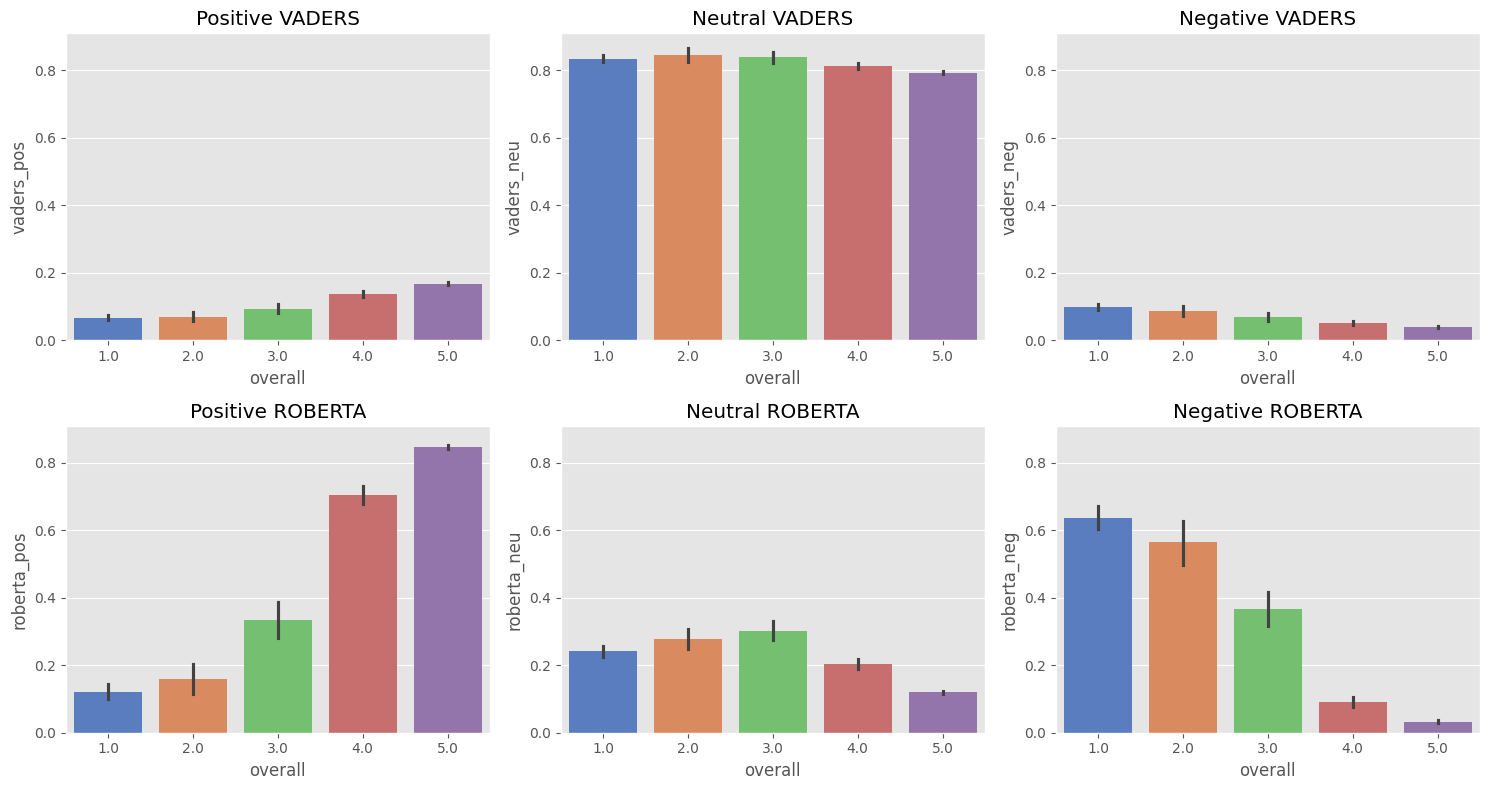

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 3, figsize=(15, 8))
sns.barplot(data=roberta_vaders_df, x='overall', y='vaders_pos', ax=axs[0, 0], hue='overall', palette="muted", dodge=False, legend=False)
sns.barplot(data=roberta_vaders_df, x='overall', y='vaders_neu', ax=axs[0, 1], hue='overall', palette="muted", dodge=False, legend=False)
sns.barplot(data=roberta_vaders_df, x='overall', y='vaders_neg', ax=axs[0, 2], hue='overall', palette="muted", dodge=False, legend=False)
sns.barplot(data=roberta_vaders_df, x='overall', y='roberta_pos', ax=axs[1, 0], hue='overall', palette="muted", dodge=False, legend=False)
sns.barplot(data=roberta_vaders_df, x='overall', y='roberta_neu', ax=axs[1, 1], hue='overall', palette="muted", dodge=False, legend=False)
sns.barplot(data=roberta_vaders_df, x='overall', y='roberta_neg', ax=axs[1, 2], hue='overall', palette="muted", dodge=False, legend=False)
axs[0, 0].set_title('Positive VADERS')
axs[0, 1].set_title('Neutral VADERS')
axs[0, 2].set_title('Negative VADERS')
axs[1, 0].set_title('Positive ROBERTA')
axs[1, 1].set_title('Neutral ROBERTA')
axs[1, 2].set_title('Negative ROBERTA')

# Synchronize y-axis limits
y_min = 0
y_max = max(ax.get_ylim()[1] for ax in axs.flat)  # Find the maximum y limit across all subplots
for ax in axs.flat:
    ax.set_ylim(y_min, y_max)  # Set consistent y-axis limits for all subplots

plt.tight_layout()
plt.show()

# Cross check

- Both RoBERTa and VADER may assign positive scores to comments where some favorable aspects are mentioned, even if they are followed by negative remarks about the product. Similarly, when negative words (e.g., "terrible," "ridiculous") are present, the model still assigns negative scores, even if the overall comment is positive.

- However, this is not a significant issue, especially for RoBERTa, as the average positive or negative scores for such comments remain low, reflecting the overall sentiment accurately.

In [53]:
# Instances where overall rating is 1 but roberta assign high positive score
roberta_vaders_df.query('overall == 1').sort_values('roberta_pos', ascending=False)['reviewText'].values[:3]

array(['I returned to order a 11.6 laptop so I could have full operations than having a Notebook. I am sure this is good quality as I have purchased San Disk numerous times.',
       "I have zero complaints, this card does exactly what it should. I'm amazed by how inexpensive memory cards continue to get. These things are really useful to throw on your keychain because they're so small.Update: From 5 stars to 1. Dead after 4 months. Appears to be a fairly common issue: [...] Let's see how the RMA process goes....",
       'I can say that SanDisk is one of the best company in the fields of electronics and Digital Cameras, but I am very dissapointed of this Memory Card.The card memory is only 25GB and the speed is 14MB/s which is not as advertised.I gave it to my dad to use it on his phone and I started to use the Sony 32GB MicroSD. I can say that it works perfectly: the storage is 32GB and the speed is 43MB/s.Buy it now: http://amzn.to/1iGqMVm . This is the exact link I used to buy mine

In [54]:
roberta_vaders_df.query('overall == 1').sort_values('vaders_pos', ascending=False)['reviewText'].values[:3]

array(['Crashed... Lost everything... Thanks SanDisk.  Used in gs4..not a solid product couple years worth of stuff gone in an instant.',
       'The card only read as 27 GB not 64 GB. I have formatted in various formats with various tools, and operating systems. I ordered a replacement and concluded this was a dud. Good luck buying this product, rest assured amazon has a good return policy.',
       "Fast card while it worked.  Died less than a week after return period expired....  Must note though that that is the nature of any memory storage card or drive.  Some fail, some last forever.  Not SanDisk's fault, not amazons fault - it is what it is.  BUT it is for this reason that i think Amazon should extend the return period on items which fall into this category.  Dont worry amazon, i still love you - but feel like your played the role of a proctologist on this one..."],
      dtype=object)

In [55]:
roberta_vaders_df.query('overall == 5').sort_values('roberta_neg', ascending=False)['reviewText'].values[:3]

array(["I only buy thru Amazon I've tried eBay and you always come thru and I got messed over four times and no real recourse you just lose and PayPal is nobodies pal. And these no more rack are terrible and all these others take my advise stick with the one that has always came thru every time for me. Amazon and only Amazon . H.Rhodes",
       'Appears to be Class 10, holds about as much as it says it does, came with an SD card adapter and they even gave me the option to forgo those ridiculous plastic packages that you all know and hate. The ones that the scissors refuse to cut and you just end up hurting yourself a few times before getting it open. Completely as advertised.',
       'My only problem is that I have not been able to use its full potential.'],
      dtype=object)

In [56]:
roberta_vaders_df.query('overall == 5').sort_values('vaders_neg', ascending=False)['reviewText'].values[:3]

array(['No problems!', 'No issues.', 'Doing its thing, no complaints'],
      dtype=object)

# Word cloud

- Most reviews mentions product names like card, phone, memory and sandisk.
- In term of features, works, great, price and fast are the top most repeated features.

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


           Word  Count
31         card   4345
7         phone   1673
14        works   1547
109       great   1453
8        memory   1338
...         ...    ...
4541    memoria      1
4542  alamcenar      1
4543     damned      1
4544    surpass      1
7582         sk      1

[7583 rows x 2 columns]


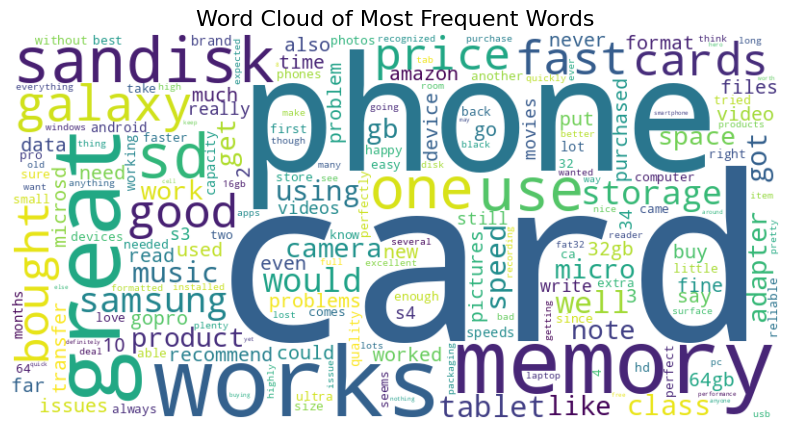

In [48]:
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

# Tokenize words and remove stopwords
stop_words = set(stopwords.words('english'))
all_words = []

for text in roberta_vaders_df['reviewText']:
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    filtered_words = [word for word in tokens if word.isalnum() and word not in stop_words]
    all_words.extend(filtered_words)

# Count word frequencies
word_counts = Counter(all_words)

# Convert to DataFrame for ranking
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count']).sort_values(by='Count', ascending=False)
print(word_freq_df)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words', fontsize=16)
plt.show()

# Appendix

# Topic modeling: Latent Dirichlet Allocation (LDA)
The dataset contains reviews of a wide range of products on an e-commerce platform. We could classify each review by product category, enabling targeted sentiment analysis if we want to better understand customer opinions on specific products group.

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Preprocess the text
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english") # words need to appear in less than 95% of the document but no less than 2 documents to be included
dtm = vectorizer.fit_transform(df["reviewText"].dropna())

# Fit the LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)  # Choose 10 categories
lda.fit(dtm)

# Display the top words for each topic
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic 0:
['10', 'cards', 'data', 'memory', 'class', 'phone', 'adapter', 'micro', 'sd', 'card']
Topic 1:
['just', 'exfat', 'read', 'formatted', 'work', 'phone', 'card', 'works', 'fat32', 'format']
Topic 2:
['memory', 'tablet', 'bought', 'storage', 'card', 'phone', 'works', 'samsung', 'note', 'galaxy']
Topic 3:
['files', 'movies', 'computer', 'storage', 'memory', 'sd', 'space', 'music', 'phone', 'card']
Topic 4:
['cards', 'tried', 'amazon', 'sd', 'just', 'problem', 'months', 'sandisk', 'phone', 'card']
Topic 5:
['write', 'gb', '10', 'sandisk', 'sd', 'tablet', 'speed', 'cards', '34', 'card']
Topic 6:
['pro', 'bought', 'surface', 'video', 'card', 'camera', 'use', 'great', 'gopro', 'works']
Topic 7:
['product', 'galaxy', 'good', 'phone', 'fast', 'card', 'price', 'memory', 'works', 'great']
Topic 8:
['buy', 'good', 'speed', 'price', '10', 'memory', 'class', 'card', 'cards', 'sandisk']
Topic 9:
['works', 'recording', 'fast', 'high', 'hd', 'use', 'disk', 'good', 'video', 'camera']


In [58]:
# Assign the most likely topic to each review
df = df.dropna(subset=["reviewText"])  # Drop rows with missing review text to align with dtm
topic_distributions = lda.transform(dtm)  # Get topic probabilities for each review
df["TopicID"] = topic_distributions.argmax(axis=1)  # Most likely topic ID for each review

# Check the updated dataframe
print(df.head())

       reviewerID        asin  reviewerName helpful  \
0  A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]   
1  A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]   
2  A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]   
3   A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]   
4  A375ZM4U047O79  B007WTAJTO  2&amp;1/2Men  [0, 0]   

                                          reviewText  overall  \
0                                         No issues.      4.0   
1  Purchased this for my device, it worked as adv...      5.0   
2  it works as expected. I should have sprung for...      4.0   
3  This think has worked out great.Had a diff. br...      5.0   
4  Bought it with Retail Packaging, arrived legit...      5.0   

                                  summary  unixReviewTime  reviewTime  \
0                              Four Stars      1406073600  2014-07-23   
1                           MOAR SPACE!!!      1382659200  2013-10-25   
2               nothing to really say....      1356220800  

I asked chatgpt to suggest product type based on keywords for each topic. Below is the result:

**Summary Table:**
- Topic 0	MicroSD cards for phones
- Topic 1	Formatting SD cards
- Topic 2	Memory cards for Samsung devices
- Topic 3	SD cards for storing media files
- Topic 4	Sandisk SD cards
- Topic 5	High-speed SD cards for tablets
- Topic 6	SD cards for GoPro cameras
- Topic 7	Affordable SD cards
- Topic 8	Class 10 SD cards
- Topic 9	High-speed SD cards for video recording

In [59]:
product_dict = {
    0: "MicroSD cards for phones",
    1: "Formatting SD cards",
    2: "Memory cards for Samsung devices",
    3: "PSD cards for storing media files",
    4: "Sandisk SD cards",
    5: "High-speed SD cards for tablets",
    6: "SD cards for GoPro cameras",
    7: "General SD cards",
    8: "Class 10 SD cards",
    9: "High-speed SD cards for video recording",
}

In [60]:
# Map TopicID to Product names
df["Product"] = df["TopicID"].map(product_dict)

# Check the resulting dataframe
print(df.head())

       reviewerID        asin  reviewerName helpful  \
0  A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]   
1  A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]   
2  A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]   
3   A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]   
4  A375ZM4U047O79  B007WTAJTO  2&amp;1/2Men  [0, 0]   

                                          reviewText  overall  \
0                                         No issues.      4.0   
1  Purchased this for my device, it worked as adv...      5.0   
2  it works as expected. I should have sprung for...      4.0   
3  This think has worked out great.Had a diff. br...      5.0   
4  Bought it with Retail Packaging, arrived legit...      5.0   

                                  summary  unixReviewTime  reviewTime  \
0                              Four Stars      1406073600  2014-07-23   
1                           MOAR SPACE!!!      1382659200  2013-10-25   
2               nothing to really say....      1356220800  

In [65]:
# Count rows for each TopicID
topic_counts = df['Product'].value_counts().sort_values(ascending = 0)

# Print the counts
topic_counts

,count
Product,
General SD cards,1233
MicroSD cards for phones,546
Sandisk SD cards,535
Class 10 SD cards,516
PSD cards for storing media files,467
Memory cards for Samsung devices,457
SD cards for GoPro cameras,442
High-speed SD cards for tablets,351
Formatting SD cards,192


Then, we can use this grouping and analyze reviews by product using the RoBERTa method as demonstrated in the first section.